In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as dsets

from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [14]:
torch.manual_seed(2323)
use_gpu = False

# Hyper Parameters 
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 200
batch_size = 100
learning_rate = 0.1

In [15]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

trainset = datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

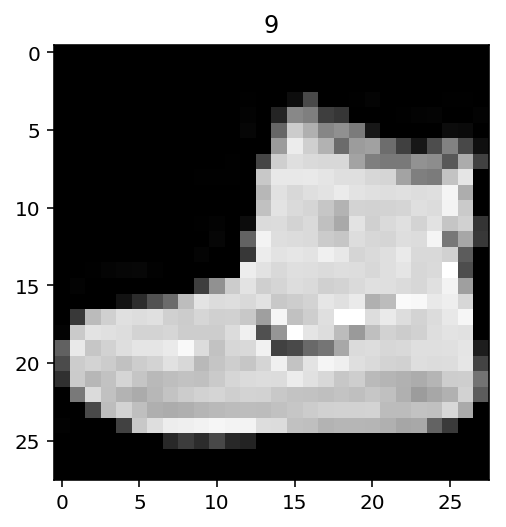

In [16]:
plt.imshow(train_loader.dataset.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_loader.dataset.train_labels[0])
plt.show()

In [20]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)  
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        out = self.fc3(x)
        return out

In [21]:
model = Net(input_size, hidden_size, num_classes)

if use_gpu:
    model.cuda()
    
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=learning_rate, 
                            weight_decay = 0.001,
                            momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min') #StepLR(optimizer, step_size=100)

In [23]:
total_trainloss = []
total_testloss  = []
# Train the Model
for epoch in range(num_epochs):
    #Train step
    epoch_trainloss = []
    for i, (train_images, train_labels) in enumerate(train_loader):  
        if use_gpu:
            train_images, train_labels = train_images.cuda(), train_labels.cuda()
        # Convert torch tensor to Variable
        train_images = Variable(train_images.view(-1, 28*28))
        train_labels = Variable(train_labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        train_outputs = model(train_images)
        train_loss = criterion(train_outputs, train_labels)
        train_loss.backward()
        optimizer.step()
        
        epoch_trainloss.append(train_loss.data[0])
    total_trainloss.append(np.mean(epoch_trainloss))
    scheduler.step(np.mean(epoch_trainloss))
    #Test step
    epoch_testloss = []
    for _, (test_images, test_labels) in enumerate(test_loader):
        if use_gpu:
            train_images, train_labels = train_images.cuda(), train_labels.cuda()
        test_images = Variable(test_images.view(-1, 28*28), volatile=True)
        test_labels = Variable(test_labels)
        
        #Forward
        test_outputs = model(test_images)
        test_loss = criterion(test_outputs, test_labels)
        epoch_testloss.append(test_loss.data[0])
    total_testloss.append(np.mean(epoch_testloss))

    print (f'''Epoch {epoch+1}/{num_epochs}, 
    trainloss: {np.mean(epoch_trainloss)}, 
    testloss : {np.mean(epoch_testloss)}''')

Epoch 1/200, 
    trainloss: 0.3657776683817307, 
    testloss : 0.37806364476680754
Epoch 2/200, 
    trainloss: 0.3297279432415962, 
    testloss : 0.3738932466506958
Epoch 3/200, 
    trainloss: 0.30991833984851835, 
    testloss : 0.37711641922593114
Epoch 4/200, 
    trainloss: 0.29376821272075176, 
    testloss : 0.3666425776481628
Epoch 5/200, 
    trainloss: 0.2805272951970498, 
    testloss : 0.32883623987436295
Epoch 6/200, 
    trainloss: 0.27569102723151445, 
    testloss : 0.37205896124243737
Epoch 7/200, 
    trainloss: 0.26555351212620737, 
    testloss : 0.3305279530584812
Epoch 8/200, 
    trainloss: 0.2612779147053758, 
    testloss : 0.34748687148094176
Epoch 9/200, 
    trainloss: 0.2522861740738154, 
    testloss : 0.35659206330776216
Epoch 10/200, 
    trainloss: 0.2522437721366684, 
    testloss : 0.32469694316387177
Epoch 11/200, 
    trainloss: 0.2436067116757234, 
    testloss : 0.3375621348619461
Epoch 12/200, 
    trainloss: 0.2418052272622784, 
    testloss

Process Process-614:
Process Process-615:
Process Process-613:
Process Process-616:
Traceback (most recent call last):
  File "/home/dsteinar/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dsteinar/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dsteinar/miniconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/dsteinar/miniconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/dsteinar/miniconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
KeyboardInterrupt
  File "/home/dsteinar/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recen

KeyboardInterrupt: 

  File "/home/dsteinar/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/dsteinar/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dsteinar/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/dsteinar/miniconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/dsteinar/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dsteinar/miniconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/dsteinar/miniconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/dsteinar/miniconda3/lib/python3.6/multiprocessing/queue

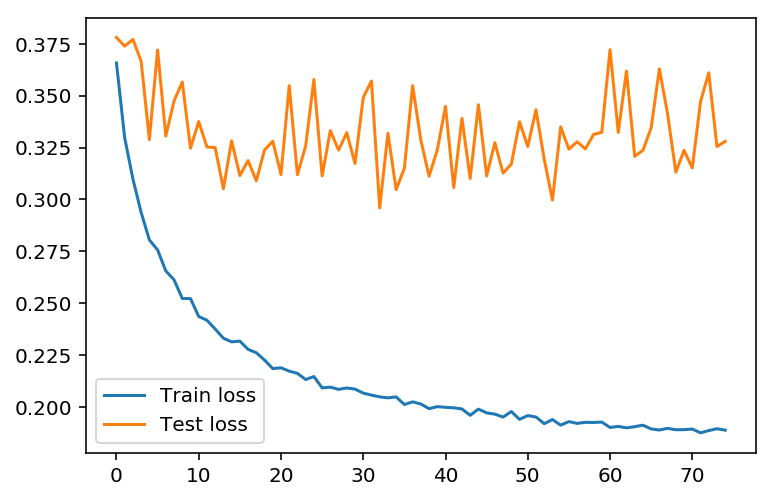

In [24]:
plt.plot(total_trainloss, label='Train loss')
plt.plot(total_testloss, label='Test loss')
plt.legend()

In [27]:
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, 28*28))
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print(f'Testset accuracy: {correct/total}')

Testset accuracy: 0.8752


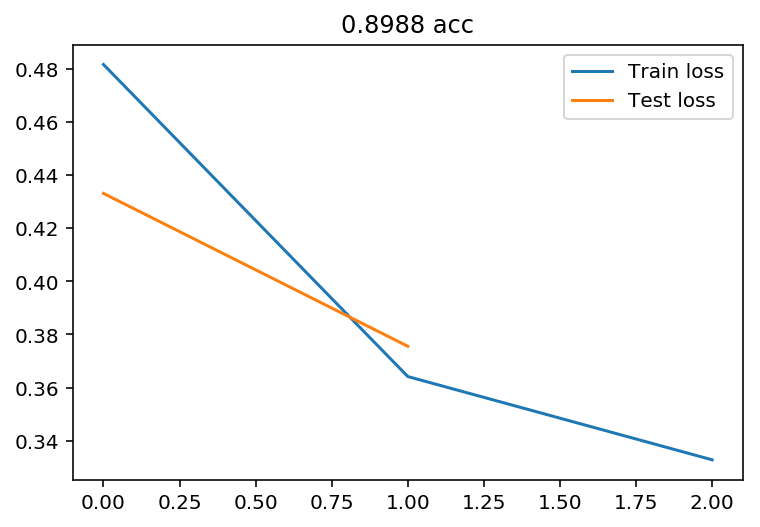

In [70]:
plt.plot(total_trainloss, label='Train loss')
plt.plot(total_testloss, label='Test loss')
plt.title('0.8988 acc')
plt.legend()

In [26]:
scheduler.optimizer.param_groups

[{'dampening': 0,
  'lr': 0.1,
  'momentum': 0.5,
  'nesterov': False,
  'params': [Parameter containing:
   -4.8094e-04 -4.2309e-04 -1.7376e-03  ...  -2.9203e-03 -3.1826e-03 -1.8178e-03
   -8.0732e-05 -1.1802e-04  1.0058e-04  ...   7.6484e-04 -4.4971e-05  3.8822e-04
    8.9062e-03  8.9868e-03  7.7222e-03  ...   7.5702e-03  7.9878e-03  8.9244e-03
                   ...                   ⋱                   ...                
   -1.6018e-03 -2.0280e-03 -3.8596e-03  ...  -2.3076e-03 -7.1047e-04 -1.5812e-03
   -1.3493e-03 -5.5446e-04  3.9042e-03  ...   9.6199e-03  5.2575e-04 -1.4560e-03
   -9.5199e-03 -9.3480e-03 -9.0120e-03  ...  -1.1918e-02 -1.3923e-02 -9.8070e-03
   [torch.FloatTensor of size 500x784], Parameter containing:
   1.00000e-02 *
     0.0975
    -0.0359
    -2.0768
     2.7010
    -1.4150
     0.2427
     0.1874
    -4.1590
     1.0938
     0.9110
     0.9439
     0.0725
     1.1951
    -0.8085
    -0.2391
     1.8530
     0.8520
    -0.4513
    -3.4112
    -2.6167
     0.3